## "MarketAnalyticTool" for quantative analysis of stocks
---

**Created By Paras Patange**


**Goal:** To create a tool which will utilise data from the web and compute popular performance metrics.


**Import Statements:**

In [98]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import sklearn
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt



Small Test If Data Can be Grabbed

In [99]:

# Define the stock tickers and time period
tickers = ["AMZN","TSLA","MSFT"]
# , "TSLA", "GOOGL", "MSFT"
start_date = "2023-05-01"
end_date = "2023-12-04"

# Fetch historical stock prices
data = yf.download(tickers, start=start_date, end=end_date)

# Display the first few rows of the data
print(data.head())
print("LENGTH IS", len(data))


[*********************100%%**********************]  3 of 3 completed
             Adj Close                               Close              \
                  AMZN        MSFT        TSLA        AMZN        MSFT   
Date                                                                     
2023-05-01  102.050003  303.633057  161.830002  102.050003  305.559998   
2023-05-02  103.629997  303.484009  160.309998  103.629997  305.410004   
2023-05-03  103.650002  302.480377  160.610001  103.650002  304.399994   
2023-05-04  104.000000  303.484009  161.199997  104.000000  305.410004   
2023-05-05  105.660004  308.690948  170.059998  105.660004  310.649994   

                              High                                 Low  \
                  TSLA        AMZN        MSFT        TSLA        AMZN   
Date                                                                     
2023-05-01  161.830002  105.230003  308.600006  163.279999  101.820000   
2023-05-02  160.309998  103.900002  309.17

# For Data which is not on Us Stock exchange, please run the following code
- Make the following change for stocks on the Indian Exchange (Ticker + ".NS")

In [100]:

# # Define the stock tickers and time period for Indian stocks
# tickers = ["NATIONALUM.NS", "CENTRALBK.NS"]
# start_date = "2015-05-01"
# end_date = "2023-12-04"

# # Fetch historical stock prices for Indian stocks
# data = yf.download(tickers, start=start_date, end=end_date)

# # Display the first few rows of the data
# print(data.head())
# print("LENGTH IS", len(data))

If unstacked dataframe is required, run the following:

In [101]:
# Unstack the multi-level columns
df_unstacked = data.stack(level=0)

# Display the unstacked dataframe
print(df_unstacked)

                              AMZN          MSFT          TSLA
Date                                                          
2023-05-01 Adj Close  1.020500e+02  3.036331e+02  1.618300e+02
           Close      1.020500e+02  3.055600e+02  1.618300e+02
           High       1.052300e+02  3.086000e+02  1.632800e+02
           Low        1.018200e+02  3.051500e+02  1.588300e+02
           Open       1.049500e+02  3.069700e+02  1.631700e+02
...                            ...           ...           ...
2023-12-01 Close      1.470300e+02  3.745100e+02  2.388300e+02
           High       1.472500e+02  3.781600e+02  2.401900e+02
           Low        1.455500e+02  3.713100e+02  2.319000e+02
           Open       1.460000e+02  3.767600e+02  2.331400e+02
           Volume     3.992460e+07  3.302040e+07  1.211735e+08

[900 rows x 3 columns]


Visualise the data with matplotlib:

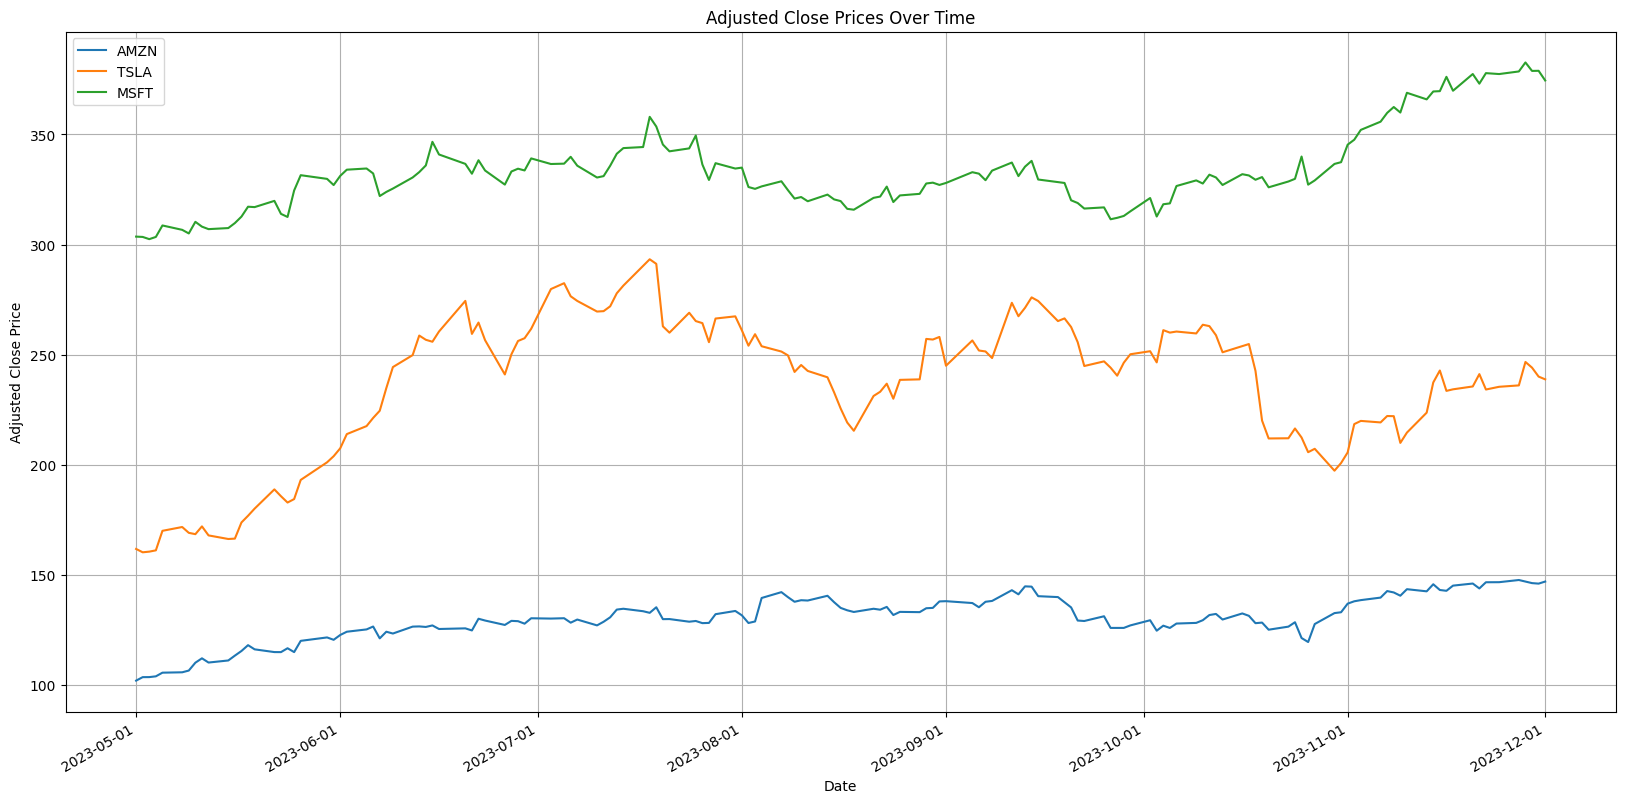

In [102]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Plotting
plt.figure(figsize=(20, 10))

if len(tickers) == 1:
    ticker = tickers[0]
    if isinstance(data.index, pd.DatetimeIndex):
        plt.plot(data.index, data['Adj Close'][ticker], label=ticker)
else:
    for ticker in tickers:
        if isinstance(data.index, pd.DatetimeIndex):
            plt.plot(data.index, data['Adj Close'][ticker], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()



**RISK ANALYSIS ATTEMPT**

***Volatility:***

Definition: Volatility measures the degree of variation of a trading price series over time. It is a statistical measure of the dispersion of returns for a given security or market index.
Interpretation: Higher volatility indicates greater potential for price fluctuations, reflecting increased market uncertainty or risk.
Sharpe Ratio:

Definition: The Sharpe ratio is a measure of risk-adjusted return. It calculates the excess return (return above the risk-free rate) per unit of risk (volatility).
Interpretation: A higher Sharpe ratio indicates a better risk-adjusted performance. It helps investors assess the return earned for the amount of risk taken.

***Value at Risk (VaR):***

Definition: VaR is a measure of the potential loss on an investment over a specific time period at a given confidence level. It quantifies the maximum loss that might occur, assuming normal market conditions.
Interpretation: A VaR of 5% at a 95% confidence level means there is a 5% chance that losses will exceed the calculated VaR.

***Cumulative Returns:***

Definition: Cumulative returns show the total returns of an investment over a specific time period. It is calculated by multiplying the daily return ratios over time.
Interpretation: Cumulative returns provide a straightforward way to assess the overall performance of an investment from the beginning to the end of the chosen period.

***Drawdown:***

Definition: Drawdown measures the peak-to-trough decline during a specific period for an investment. It represents the percentage decline from the highest cumulative return to the lowest point.
Interpretation: Drawdown helps investors understand the risk of a particular investment by quantifying the magnitude of losses experienced during a downturn.

***Maximum Drawdown:***

Definition: Maximum drawdown is the maximum percentage loss from the peak to the trough of an investment during a specified time period.
Interpretation: It provides a measure of the largest potential loss an investor could have experienced during the worst-performing period of the investment.

In [103]:
import numpy as np
from scipy.stats import norm

# Calculate volatility
daily_returns = data['Adj Close'].pct_change()
volatility = daily_returns.std()

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

# Calculate Value at Risk (VaR)
confidence_level = 0.95
var = norm.ppf(1 - confidence_level, daily_returns.mean(), daily_returns.std())

# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod()

# Calculate drawdown and maximum drawdown
peak = cumulative_returns.cummax()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()

# Print or use the calculated metrics as needed
print("Metrics:")
print("------------------------------------------------------------------------------------------------------------------------------------")
print("Volatility:", volatility)
print("  ")
print("-------------------------")
print("Sharpe Ratio:", sharpe_ratio)
print("  ")
print("-------------------------")
print(f"Value at Risk (VaR) at {confidence_level * 100}% confidence level:", var)
print("  ")
print("-------------------------")
print("Maximum Drawdown:", max_drawdown)


Metrics:
------------------------------------------------------------------------------------------------------------------------------------
Volatility: AMZN    0.019452
MSFT    0.013995
TSLA    0.030651
dtype: float64
  
-------------------------
Sharpe Ratio: AMZN    2.154936
MSFT    1.708580
TSLA    1.595937
dtype: float64
  
-------------------------
Value at Risk (VaR) at 95.0% confidence level: [-0.02935581 -0.02151378 -0.04733512]
  
-------------------------
Maximum Drawdown: AMZN   -0.174525
MSFT   -0.129876
TSLA   -0.327197
dtype: float64


Visualisation:

IndexError: index 1682899200000000000 is out of bounds for axis 0 with size 150

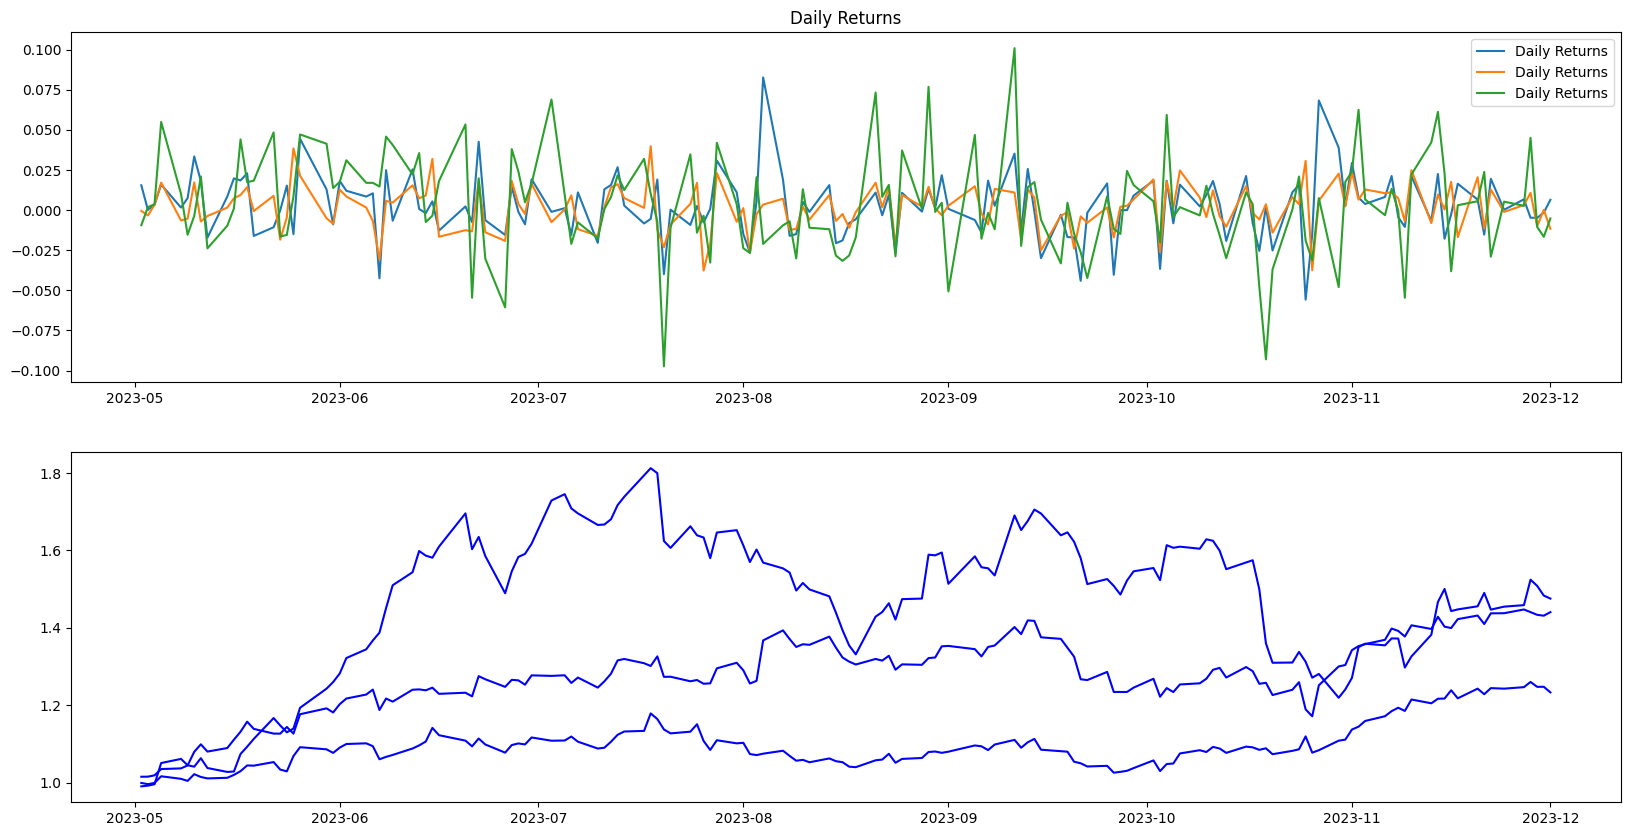

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming daily_returns, cumulative_returns, and max_drawdown are already defined

# Increase the figure size
plt.figure(figsize=(20, 10))

# Plotting daily returns
plt.subplot(2, 1, 1)
plt.plot(daily_returns, label='Daily Returns')
plt.title('Daily Returns')
plt.legend()

# Plotting cumulative returns and highlighting maximum drawdown
plt.subplot(2, 1, 2)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')

# Create an array of zeros with the same length as cumulative_returns
zero_line = np.zeros_like(cumulative_returns)

# Highlighting maximum drawdown
drawdown_threshold = 0.05  # Set a threshold for drawdown visibility
highlight_drawdown = drawdown[drawdown < -drawdown_threshold]

# Convert indices to integer values
highlight_drawdown_indices = highlight_drawdown.index.astype(int)

plt.fill_between(
    x=highlight_drawdown_indices,
    y1=zero_line[highlight_drawdown_indices],
    y2=cumulative_returns[highlight_drawdown_indices],
    color='red', alpha=0.3, label='Drawdown'
)


plt.title('Cumulative Returns with Maximum Drawdown')
plt.legend()
plt.tight_layout()
plt.show()



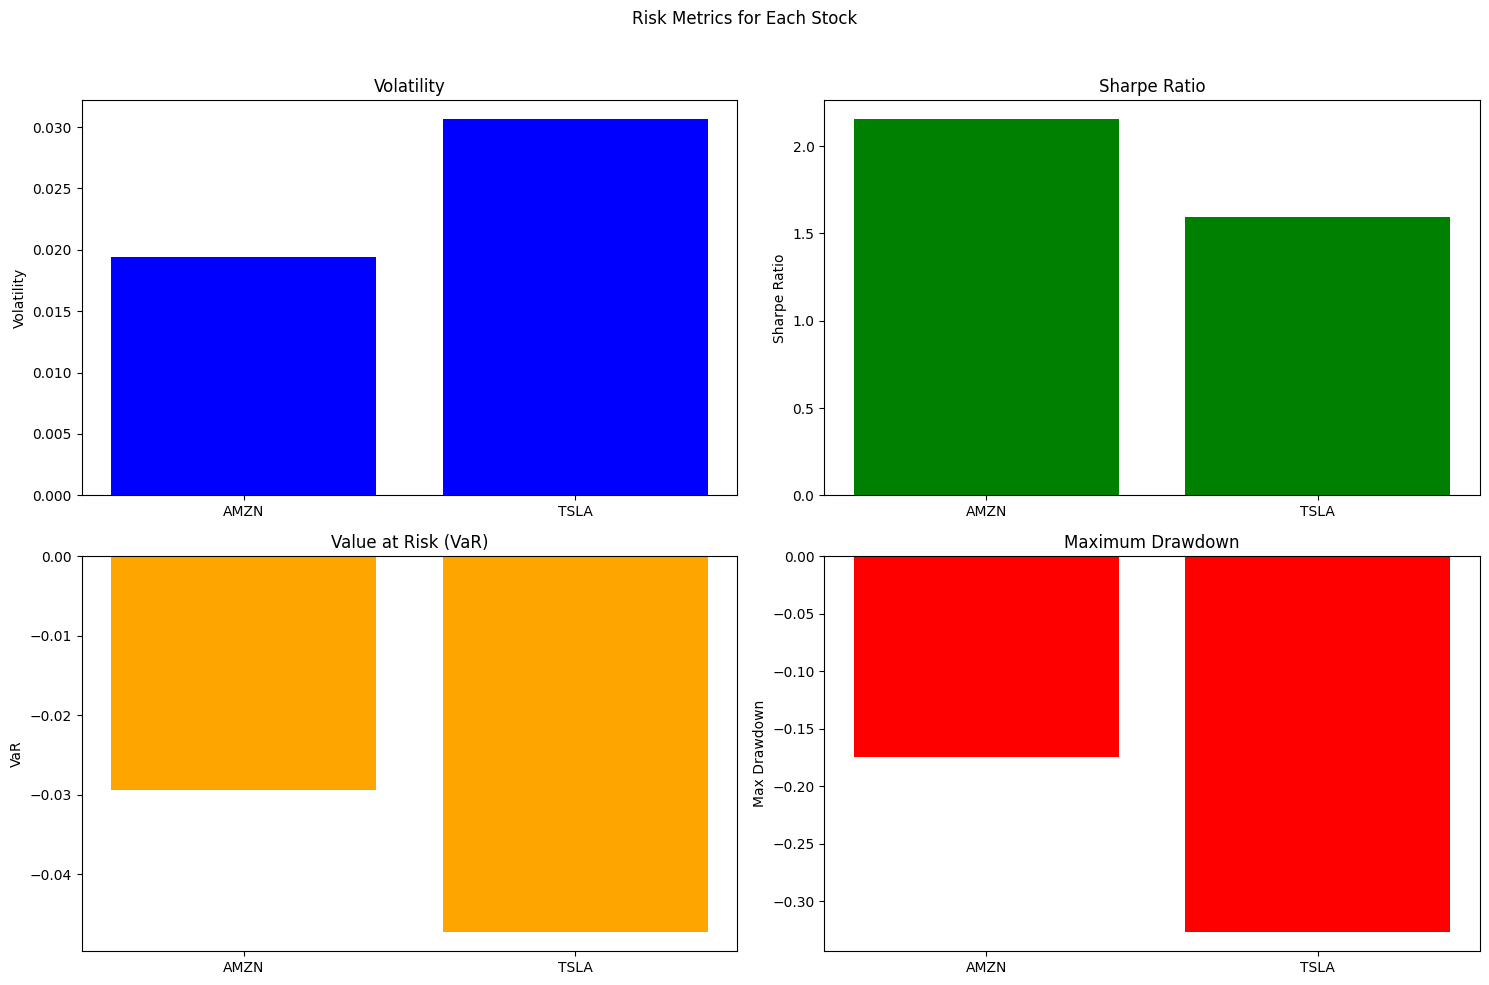

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Initialize lists to store metrics for each stock
volatilities = []
sharpe_ratios = []
vars = []
max_drawdowns = []

# Calculate metrics for each stock
for ticker in tickers:
    # Calculate daily returns
    daily_returns = data['Adj Close'][ticker].pct_change().dropna()

    # Calculate volatility
    volatility = daily_returns.std()
    volatilities.append(volatility)

    # Calculate Sharpe ratio
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    sharpe_ratios.append(sharpe_ratio)

    # Calculate Value at Risk (VaR)
    confidence_level = 0.95
    var = norm.ppf(1 - confidence_level, daily_returns.mean(), daily_returns.std())
    vars.append(var)

    # Calculate drawdown and maximum drawdown
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    max_drawdowns.append(max_drawdown)

# Create subplots for each metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Risk Metrics for Each Stock')

# Volatility
axes[0, 0].bar(tickers, volatilities, color='blue')
axes[0, 0].set_title('Volatility')
axes[0, 0].set_ylabel('Volatility')

# Sharpe Ratio
axes[0, 1].bar(tickers, sharpe_ratios, color='green')
axes[0, 1].set_title('Sharpe Ratio')
axes[0, 1].set_ylabel('Sharpe Ratio')

# Value at Risk (VaR)
axes[1, 0].bar(tickers, vars, color='orange')
axes[1, 0].set_title('Value at Risk (VaR)')
axes[1, 0].set_ylabel('VaR')

# Maximum Drawdown
axes[1, 1].bar(tickers, max_drawdowns, color='red')
axes[1, 1].set_title('Maximum Drawdown')
axes[1, 1].set_ylabel('Max Drawdown')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



Portfolio Construction:


Optimal Weights:
AMZN: 0.5187
TSLA: 0.3158
MSFT: 0.1654


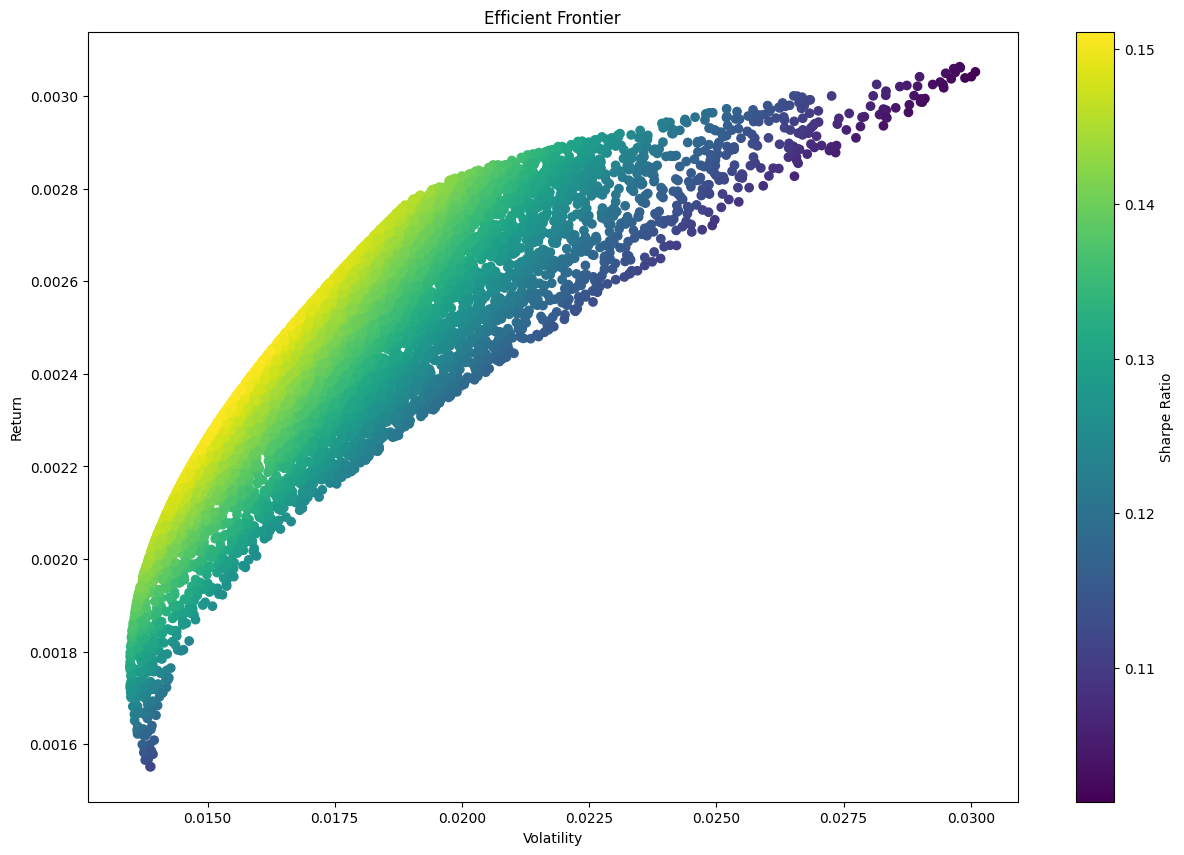

In [107]:


# Calculate mean returns
mean_returns = daily_returns.mean()

# Calculate covariance matrix
cov_matrix = daily_returns.cov()

# Convert the DataFrame to a NumPy array for optimization
mean_returns_array = mean_returns.values
cov_matrix_array = cov_matrix.values

# Define optimization objective function
def objective(weights):
    portfolio_return = np.dot(weights, mean_returns_array)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_array, weights)))
    return -portfolio_return / portfolio_volatility  # Negative Sharpe ratio to maximize

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights between 0 and 1
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Initial weights
initial_weights = [1. / len(tickers) for _ in range(len(tickers))]

# Optimize
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = result.x

# Display optimal weights
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

# Simulate portfolios for the efficient frontier
port_returns = []
port_volatilities = []

for _ in range(10000):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    # Calculate portfolio return and volatility
    portfolio_return = np.dot(weights, mean_returns_array)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_array, weights)))

    # Append to lists
    port_returns.append(portfolio_return)
    port_volatilities.append(portfolio_volatility)

# Convert lists to NumPy arrays
port_returns = np.array(port_returns)
port_volatilities = np.array(port_volatilities)

# Plot the efficient frontier
plt.figure(figsize=(15, 10))
plt.scatter(port_volatilities, port_returns, c=port_returns/port_volatilities, marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()


**Performance Metric**

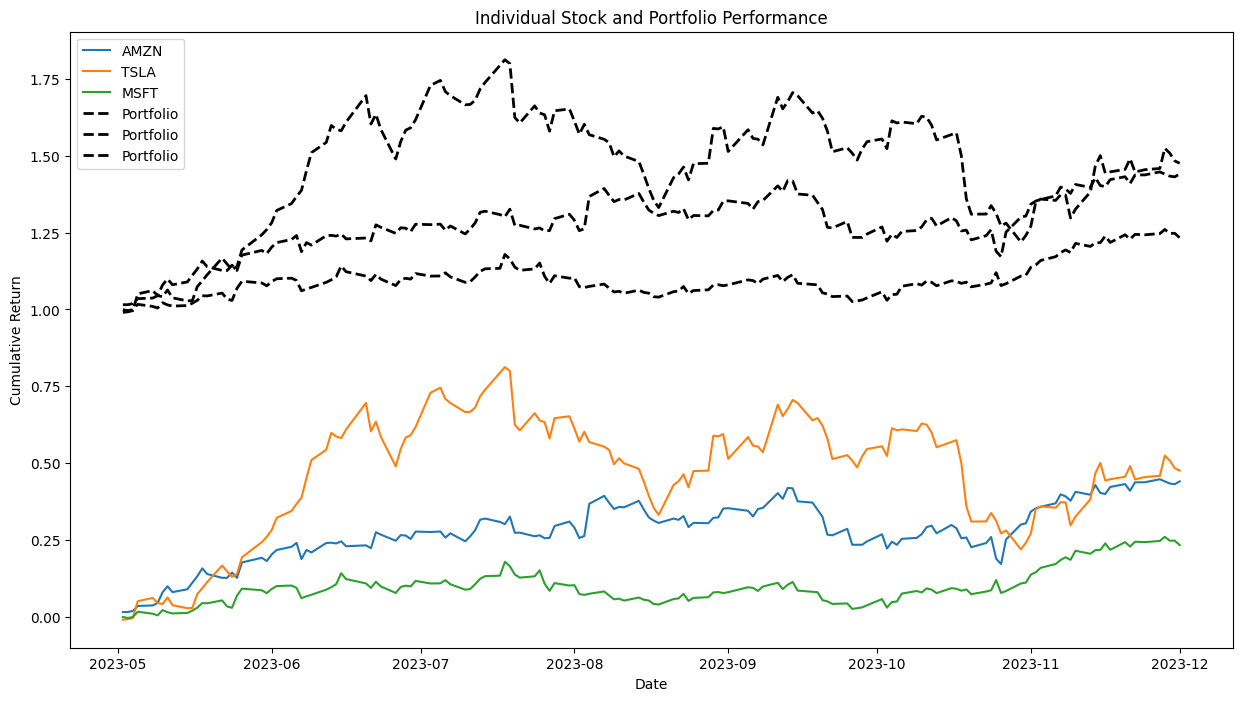

In [108]:
# Assuming individual stock prices are stored in a DataFrame named 'data'

# Calculate individual stock returns
individual_stock_returns = data['Adj Close'].pct_change()

# Calculate individual stock total returns
individual_stock_total_returns = (1 + individual_stock_returns).cumprod() - 1

# Compare individual stock and portfolio performance
plt.figure(figsize=(15, 8))

# Plot individual stock total returns
for stock in tickers:
    plt.plot(individual_stock_total_returns.index, individual_stock_total_returns[stock], label=stock)

# Plot portfolio cumulative returns
plt.plot(cumulative_returns.index, cumulative_returns, label='Portfolio', linestyle='--', linewidth=2, color='black')

plt.title('Individual Stock and Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()



**Correlation Calculation**

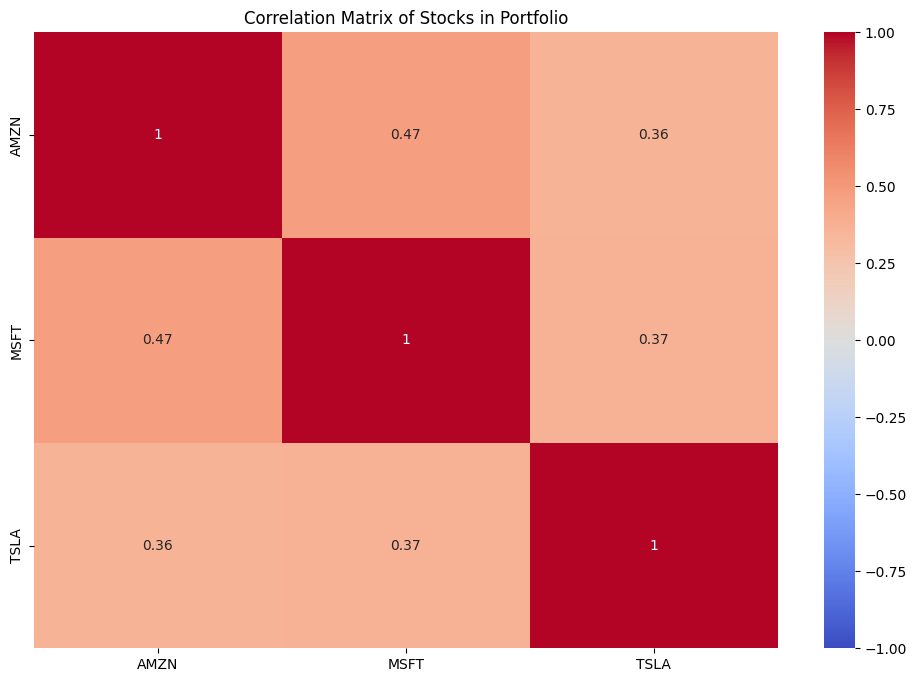

In [109]:
# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Display heatmap of the correlation matrix
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Stocks in Portfolio')
plt.show()


*** STOCK PREDICTION MODEL LSTM ***

In [120]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Fetch historical stock data for Apple Inc. (AAPL)
ticker = "AAPL"
stock_data = yf.download(ticker, start="1999-11-01", end="2021-07-09")

# Ensure datetime index
stock_data.index = pd.to_datetime(stock_data.index)

# Train-test split for time-series
test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stock_data))
test_size = int(test_ratio * len(stock_data))

# Print train and test sizes
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

# Split the data into train and test sets
train = stock_data[:train_size][["Close"]]
test = stock_data[train_size:][["Close"]]

# Helper function to split time-series data into training sequence X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i - N : i])
        y.append(data[i])

    return np.array(X), np.array(y)

# Helper function to calculate RMSE and MAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mape

# Plot the trend of the stock prices
def plot_stock_trend(var, title, stock_data=stock_data):
    fig, ax = plt.subplots(figsize=(20, 10))
    stock_data[["Close", var, "200day"]].plot(ax=ax)
    ax.grid(False)
    ax.set_title(title)
    ax.set_ylabel("Stock Price ($)")

# Calculate Simple Moving Average (SMA)
window_size = 50
stock_data[f"{window_size}day_SMA"] = stock_data["Close"].rolling(window=window_size).mean()
plot_stock_trend(var=f"{window_size}day_SMA", title="Simple Moving Averages")

# Calculate Exponential Moving Average (EMA)
stock_data[f"{window_size}day_EMA"] = stock_data["Close"].ewm(span=window_size, adjust=False).mean()
plot_stock_trend(var=f"{window_size}day_EMA", title="Exponential Moving Averages")

# LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Scale the data for LSTM
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train)
X_train, y_train = extract_seqX_outcomeY(scaled_data, window_size, window_size)

# Reshape for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build and train LSTM model
lstm_model = build_lstm_model((X_train.shape[1], 1))
lstm_model.fit(X_train, y_train, epochs=15, batch_size=20)

# Prepare test data for LSTM
scaled_test_data = scaler.transform(test)
X_test = extract_seqX_outcomeY(scaled_test_data, window_size, window_size)[0]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict using LSTM model
predicted_prices_lstm = lstm_model.predict(X_test)
predicted_prices_lstm = scaler.inverse_transform(np.reshape(predicted_prices_lstm, (-1, 1)))

# Plot LSTM predictions
test["Predictions_LSTM"] = predicted_prices_lstm
plot_stock_trend(var="Predictions_LSTM", title="LSTM Predictions")

# Display the plots
plt.show()


ModuleNotFoundError: No module named 'tensorflow'